In [17]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# siapkan direktori
base_dir = '/content/drive/MyDrive/Dataset/CarBrandImages'
!ls '/content/drive/MyDrive/Dataset/CarBrandImages'

Test  Train  val


Import drive


In [104]:
# tentukan directory bahan
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'val')

In [68]:
# tentukan direktori isi bahan
audi_dir = os.path.join(test_dir, 'audi/')
mercedes_dir = os.path.join(test_dir, 'mercedes/')

print('total gambar audi: ', len(os.listdir(audi_dir)))
print('total gambar mercedez: ', len(os.listdir(mercedes_dir)))

total gambar audi:  33
total gambar mercedez:  39


Siapkan dataset

In [69]:
# direktori isi latih/training
train_audi_dir = os.path.join(train_dir, 'audi/')
train_mercedes_dir = os.path.join(train_dir, 'mercedes/')


# direktori isi validasi
validation_audi_dir = os.path.join(validation_dir, 'audi/')
validation_mercedes_dir = os.path.join(validation_dir, 'mercedes/')

In [70]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio ):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
   i_file = source + i
   destination = train + i
   copyfile(i_file, destination)

   for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

# jumlah pembagian data training dan testing
train_ratio = 0.9

# pemanggilan training dan validasi
# training

train_00 = train_audi_dir
train_02 = train_mercedes_dir

val_00 = validation_audi_dir
val_02 = validation_mercedes_dir

# latih
source_00 = audi_dir
source_02 = mercedes_dir

train_val_split(source_00, train_00, val_00, train_ratio)
train_val_split(source_02, train_02, val_02, train_ratio)

# validasi
val_00 = validation_audi_dir
val_02 = validation_mercedes_dir

train_val_split(source_00, train_00, val_00, train_ratio)
train_val_split(source_02, train_02, val_02, train_ratio)


In [71]:
print('jumlah all audi :', len(os.listdir(audi_dir)))
print('jumlah train audi :', len(os.listdir(train_audi_dir)))
print('jumlah val audi :', len(os.listdir(validation_audi_dir)))


print('jumlah all mercedes :', len(os.listdir(mercedes_dir)))
print('jumlah train mercedes :', len(os.listdir(train_mercedes_dir)))
print('jumlah val mercedes :', len(os.listdir(validation_mercedes_dir)))

jumlah all audi : 33
jumlah train audi : 33
jumlah val audi : 33
jumlah all mercedes : 39
jumlah train mercedes : 39
jumlah val mercedes : 27


In [72]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [73]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)


In [74]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

Found 72 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [75]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
     print("/nAkurasi telah mencapai >99%!")
     self.model.stop_training = True
callbacks = myCallback()

Model CNN

In [76]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)), #
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # data 1 baris
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=112),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=112),
    tf.keras.layers.Dense(2, activation='sigmoid'),

])

In [77]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 200)                 │       3,699,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,824,486 (14.59 MB)

 Trainable params: 3,824,486 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [111]:
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=20,
    validation_data=val_generator,
    validation_steps=5,
    verbose=1,
    callbacks= [callbacks]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9765 - loss: 0.0612 - val_accuracy: 0.9600 - val_loss: 0.1511
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9822 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/20
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 1.0000 - loss: 0.0087/nAkurasi telah mencapai >99%!
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9800 - val_loss: 0.0599


Tingkat akurasi dan loss model

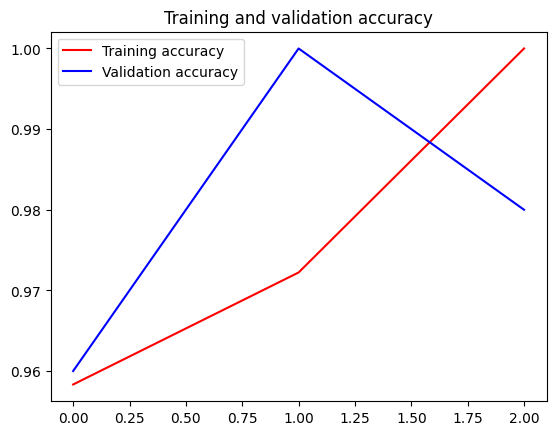

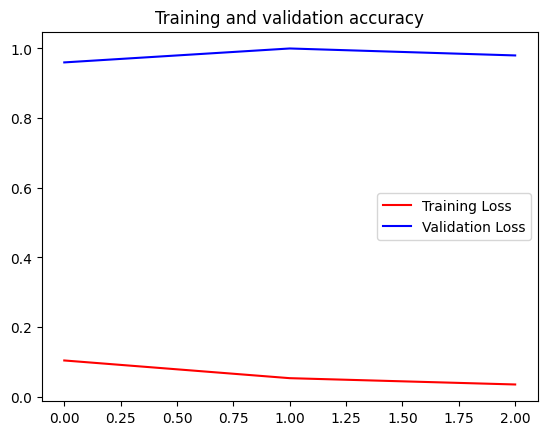

<Figure size 640x480 with 0 Axes>

In [108]:
# melihat akurasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc= 'best')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_acc, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc= 'best')
plt.figure()

plt.show()


mencoba Klassifikasi

Saving carpixel.net-2025-mercedes-amg-gt-63-s-e-performance-4-door-us-125051-hd.jpg to carpixel.net-2025-mercedes-amg-gt-63-s-e-performance-4-door-us-125051-hd (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
carpixel.net-2025-mercedes-amg-gt-63-s-e-performance-4-door-us-125051-hd (1).jpg
this image belongs to class mercedes


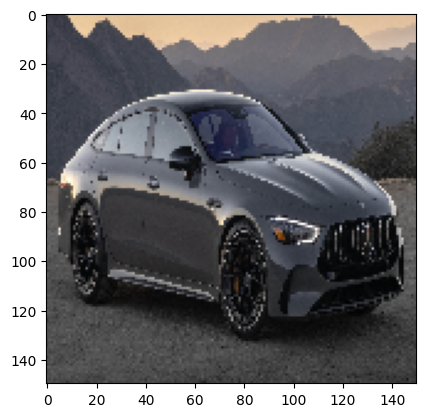

In [110]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=130)

  print(fn)

class_list = os.listdir(train_dir)
  # Change the loop to iterate over the correct range of classes
for j in range(len(class_list)):
    # Find the class with the highest probability
    predicted_class_index = np.argmax(classes[0])
    if j == predicted_class_index:
      print("this image belongs to class", class_list[j])
      break